In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl

In [4]:
from datasets.carla import *
from tools.geometry import *
from tools.utils import *
import argparse

from numpy.linalg import inv
import random
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

In [13]:
def find_center(array):
    indices = np.argwhere(array == 1)

    min_x = np.min(indices[:, 1])
    max_x = np.max(indices[:, 1])
    min_y = np.min(indices[:, 0])
    max_y = np.max(indices[:, 0])              

    center_x = (max_x + min_x) / 2
    center_y = (max_y + min_y) / 2

    return center_x, center_y


def find_dims(array):
    indices = np.where(array == 1)

    min_y = np.min(indices[0])
    max_y = np.max(indices[0])
    min_x = np.min(indices[1])
    max_x = np.max(indices[1])
    
    total_height = max_y - min_y + 1
    total_width = max_x - min_x + 1
    return total_width, total_height


def resize_image_by_height(image, new_height):
    width, height = image.size
    aspect_ratio = width / height
    new_width = int(aspect_ratio * new_height)

    resized_image = image.resize((new_width, int(new_height)))
    return resized_image


In [7]:
carla_data = CarlaDataset("../../data/carla/train", False)
carla_data.return_info = True

In [8]:
animals = ["bear", "elephant", "horse", "deer"]

cameras = [
    'left_front_camera',
    'front_camera',
    'right_front_camera',
    'left_back_camera',
    'back_camera',
    'right_back_camera'
]

sizes = [
    [2.1, 5.5, 3.5],
    [4.3, 10, 6],
    [1.75, 3.4, 3.2],
    [2.4, 4, 3],
]

  0%|                                                                                                                                                                                  | 0/40000 [00:00<?, ?it/s]


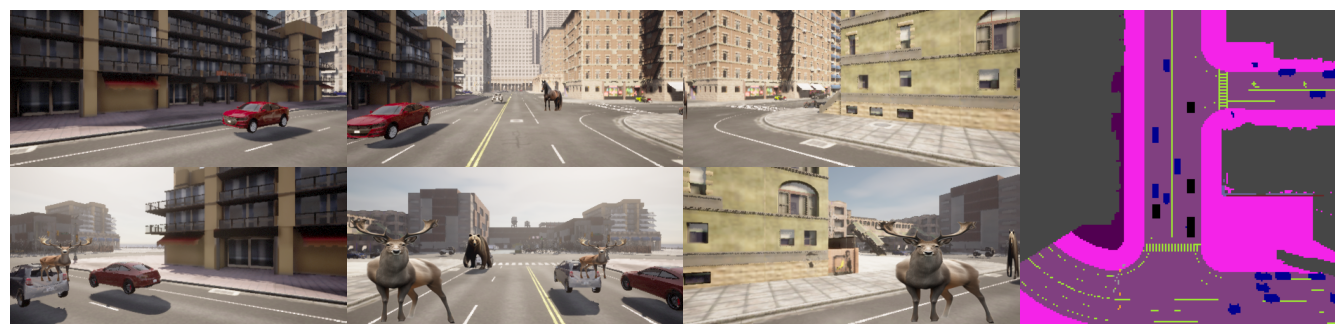

In [41]:
rat = 224/480
val = 10.1
fig = plt.figure(figsize=(val + val / 3 * rat * 2 , val/3*2*rat))
gs = mpl.gridspec.GridSpec(2, 4, width_ratios=(1, 1, 1, 2*rat))
gs.update(wspace=0.0, hspace=0.0, left=0.0, right=1.0, top=1.0, bottom=0.0)

for images, intrinsics, extrinsics, labels, oods, info in tqdm(carla_data):
    labels = labels.numpy()
    bev_seg = cv2.imread(os.path.join(info['agent_path'] + "bev_semantic", f'{info["index"]}.png'))
    cams = [Image.open(os.path.join(info['agent_path'] + cn, f'{info["index"]}.png')) for cn in cameras]

    excluded = labels[3]
    n_obj = random.randint(1, 4)

    while n_obj > 0:
        a = random.randrange(0, len(animals))
        file = random.choice(os.listdir(f"../pseudo/{animals[a]}/"))
        ood = Image.open(f"../pseudo/{animals[a]}/{file}")

        size = sizes[a]
        rot = euler_to_quaternion(0, 0, 0)
        trans = [
            random.randint(-30, 30),
            random.randint(-30, 30),
            size[2] / 2
        ]

        bev_box = draw_bev(trans, rot, size).astype(bool)

        if np.sum(excluded[bev_box]) > 0:
            continue

        bev_seg[bev_box == 1, :] = 0

        for ci, cn in enumerate(cameras):
            I = intrinsics[ci]
            E = np.linalg.inv(extrinsics[ci])

            cam_box = draw_cam(
                trans, rot, size, I, E,
                dataset='carla',
            )

            if np.sum(cam_box) > 0:
                indices = np.where(cam_box == 1)
                min_y = np.min(indices[0])
                max_y = np.max(indices[0])
                min_x = np.min(indices[1])
                max_x = np.max(indices[1])

                r_ood = ood.resize((max_x - min_x, max_y - min_y))
                cams[ci].paste(r_ood, (min_x, min_y), r_ood)

        n_obj -= 1
                            
    for i in range(6):
        ax = plt.subplot(gs[i // 3, i % 3])
        ax.imshow(cams[i])               
        ax.axis("off")

    ax = plt.subplot(gs[:, 3:4])
    ax.imshow(bev_seg)      
    ax.axis("off")
    
    break

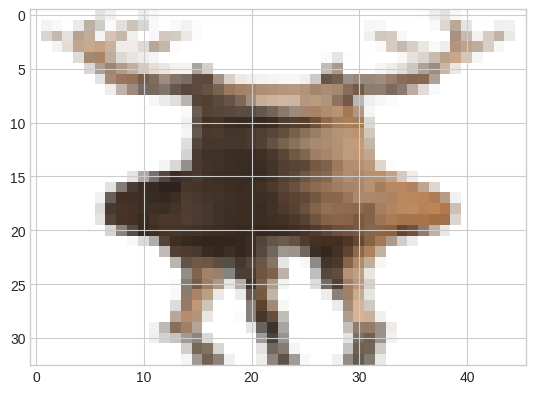

In [36]:
plt.imshow(r_ood)